In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#from darksky import forecast
import datetime as dt
#from noaa_sdk import noaa
#import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
import pickle
import descartes
from shapely.geometry import Point, Polygon

#n = noaa.NOAA()
noaakey = 'LsIneJLfjoLBjuBphdeUGyJLVJdXWRpK'
dskey = '6864d54f724e54e7c3ae08094f523ff0'

In [5]:
data = pd.read_csv('data/West_Nile_Virus__WNV__Mosquito_Test_Results.csv')
data = data.rename(columns={"TEST DATE": "date",
                            "NUMBER OF MOSQUITOES":"num",
                            "LATITUDE":"lat","LONGITUDE":"lon",
                            "TRAP":"trap",
                            "SEASON YEAR":"year",
                            "WEEK":"week",
                            "Census Tracts":"tract",
                            "Zip Codes":"zip",
                            "Community Areas":"community",
                            "Historical Wards 2003-2015":"ward"})
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date
data.drop(columns=['TEST ID','SPECIES'])
data = data.dropna()

In [18]:
crs = {'init': 'epsg:4326'}
water_map = gpd.read_file('water/chicago_latlon.shp')
lake_MI = water_map[water_map.NAME == 'LAKE MICHIGAN']

water_maps = water_map[water_map.NAME != 'LAKE MICHIGAN']
water_maps = water_maps.reset_index(drop=False)

park_map = gpd.read_file('parks/chicago_parks1.shp')
forest_map = gpd.read_file('forest/forest.shp')


by_trap = data.groupby('trap').mean()
by_trap = by_trap.reset_index(drop=False)

geometry = [Point(xy) for xy in zip(by_trap.lon,by_trap.lat)]
geo_traps = gpd.GeoDataFrame(by_trap, crs = crs, geometry = geometry)
geo_traps = geo_traps.reset_index(drop=False)

green_geo = park_map.geometry.append(forest_map.geometry)

green_map = gpd.GeoDataFrame(crs = crs, geometry = green_geo)
green_map = green_map.reset_index(drop=False)

data_geometry = [Point(xy) for xy in zip(data.lon,data.lat)]
geo_data = gpd.GeoDataFrame(data, crs = crs, geometry = data_geometry)

geo_traps['d_water'] = 0.
geo_traps['d_park'] = 0.
geo_traps['d_lm'] = 0.

for i,point in geo_traps.iterrows():
    distw = np.ones(shape=(len(water_maps),1))
    distf = np.ones(shape=(len(green_map),1))
    for j,mi in lake_MI.iterrows():
        distl = point['geometry'].distance(mi['geometry'])
    for j,lake in water_maps.iterrows():
        distw[j] = point['geometry'].distance(lake['geometry'])
    for j,tree in green_map.iterrows():
        distf[j] = point['geometry'].distance(tree['geometry'])
    geo_traps.loc[i,'d_water'] = min(distw)
    geo_traps.loc[i,'d_park'] = min(distf)
    geo_traps.loc[i,'d_lm'] = distl

geo_data['d_water'] = 0.
geo_data['d_park'] = 0.
geo_data['d_lm'] = 0.
for i,point in geo_data.iterrows():
    geo_data.loc[i,'d_water']=geo_traps[geo_traps.trap==point.trap]['d_water'].values[0]
    geo_data.loc[i,'d_park']=geo_traps[geo_traps.trap==point.trap]['d_park'].values[0]
    geo_data.loc[i,'d_lm']=geo_traps[geo_traps.trap==point.trap]['d_lm'].values[0]

In [76]:
geo_data['since']=100.
group_trap = geo_data.groupby('trap')
for trap,tdata in group_trap:
    T = tdata.sort_values(by = 'date', ascending = False)
    l = len(T) - 1
    for i in range(l):
        date = T.date.iloc[i]
        DT = (date - T.date.iloc[i+1]).total_seconds()/86400.
        ind = ((geo_data.date == date)&(geo_data.trap == trap))
        p = np.where(ind)[0]
        geo_data.since.iloc[p] = DT

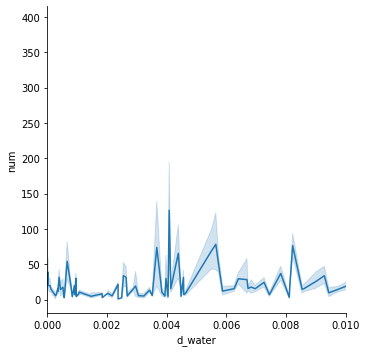

In [79]:
sns.relplot(x='d_water',y='num',kind='line',data=geo_data)
plt.xlim(0,0.01)
plt.show()

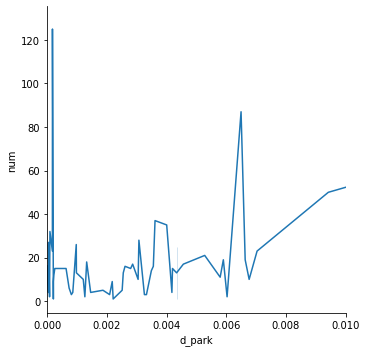

In [80]:
sns.relplot(x='d_park',y='num',kind = 'line',data=geo_data[(geo_data.year == 2019)&(geo_data.week == 25)])
plt.xlim(0,0.01)
plt.show()

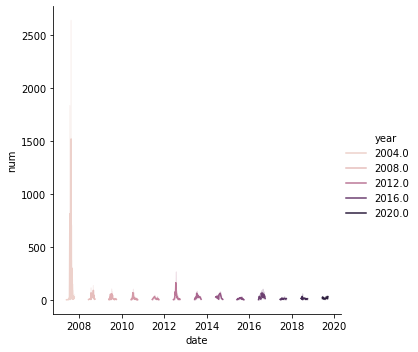

In [93]:
sns.relplot(x='date',y='num',kind='line',hue='year',data= geo_data)
plt.show()

In [22]:
w1=pd.read_csv('w1.csv')
w2=pd.read_csv('w2.csv')
w=pd.concat([w1, w2])
w.info
w = w.reset_index(drop=False)
w = w.rename(columns={"DATE": "date",
                            "PRCP":"p",
                            "TAVG":"Tavg","TMAX":"Tmax",
                            "TMIN":"Tmin","AWND":"w_sp","WDF5":"w_d"})
w['date'] = pd.to_datetime(w['date'])
w['date'] = w['date'].dt.date

/Users/ianbakst/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
geo_data['TH0']=0.
geo_data['TL1']=0.
geo_data['Tmax']=0.
geo_data['Tmin']=0.
geo_data['prec']=0.
geo_data = geo_data[(geo_data['date'] > pd.to_datetime('2007-06-11'))]

In [25]:
for i in range(len(geo_data)):
    d0 = geo_data['date'].iloc[i]
    d1 = d0 + pd.DateOffset(-1)
    d2 = d0 + pd.DateOffset(-2)
    d3 = d0 + pd.DateOffset(-3)
    d4 = d0 + pd.DateOffset(-4)
    d5 = d0 + pd.DateOffset(-5)
    d6 = d0 + pd.DateOffset(-6)
    d7 = d0 + pd.DateOffset(-7)
    d8 = d0 + pd.DateOffset(-8)
    d9 = d0 + pd.DateOffset(-9)
    d10 = d0 + pd.DateOffset(-10)
    TH0 = w[w.date == d0]['Tmax'].values[0]
    TL0 = w[w.date == d0]['Tmin'].values[0]
    TH1 = w[w.date == d1]['Tmax'].values[0]
    TL1 = w[w.date == d1]['Tmin'].values[0]
    TH2 = w[w.date == d2]['Tmax'].values[0]
    TL2 = w[w.date == d2]['Tmin'].values[0]
    TH3 = w[w.date == d3]['Tmax'].values[0]
    TL3 = w[w.date == d3]['Tmin'].values[0]
    TH4 = w[w.date == d4]['Tmax'].values[0]
    TL4 = w[w.date == d4]['Tmin'].values[0]
    TH5 = w[w.date == d5]['Tmax'].values[0]
    TL5 = w[w.date == d5]['Tmin'].values[0]
    TH6 = w[w.date == d6]['Tmax'].values[0]
    TL6 = w[w.date == d6]['Tmin'].values[0]
    TH7 = w[w.date == d7]['Tmax'].values[0]
    TL7 = w[w.date == d7]['Tmin'].values[0]
    TH8 = w[w.date == d8]['Tmax'].values[0]
    TL8 = w[w.date == d8]['Tmin'].values[0]
    TH9 = w[w.date == d9]['Tmax'].values[0]
    TL9 = w[w.date == d9]['Tmin'].values[0]
    TH10 = w[w.date == d10]['Tmax'].values[0]
    TL10 = w[w.date == d10]['Tmin'].values[0]
    Tmax = max([TH0,TH1,TH2,TH3,TH4,TH5,TH6,TH7,TH8,TH9,TH10])
    Tmin = min([TL0,TL1,TL2,TL3,TL4,TL5,TL6,TL7,TL8,TL9,TL10])
    p0 = w[w.date == d0]['p'].values[0]
    p1 = w[w.date == d1]['p'].values[0]
    p2 = w[w.date == d2]['p'].values[0]
    p3 = w[w.date == d3]['p'].values[0]
    p4 = w[w.date == d4]['p'].values[0]
    p5 = w[w.date == d5]['p'].values[0]
    p6 = w[w.date == d6]['p'].values[0] 
    p7 = w[w.date == d7]['p'].values[0]
    p8 = w[w.date == d8]['p'].values[0]
    p9 = w[w.date == d9]['p'].values[0]
    p10 = w[w.date == d10]['p'].values[0]
    precip = [p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10]
    prec=sum(precip)
    geo_data['TH0'].iloc[i]=TH0
    geo_data['TL1'].iloc[i]=TL1
    geo_data['Tmax'].iloc[i] = Tmax
    geo_data['Tmin'].iloc[i] = Tmin
    geo_data['prec'].iloc[i] = prec
print('Done')

/Users/ianbakst/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Done


In [99]:
geo_data.to_csv('test.csv')

(array([11541.,  6308.,  3787.,  1619.,   467.,   512.,   153.,    54.,
          146.,   183.]),
 array([ 0.   ,  1.074,  2.148,  3.222,  4.296,  5.37 ,  6.444,  7.518,
         8.592,  9.666, 10.74 ]),
 <a list of 10 Patch objects>)

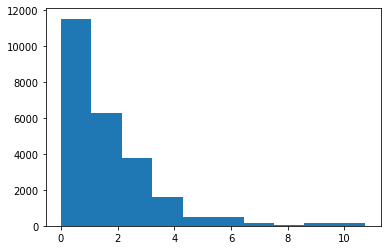

In [74]:
plt.hist(geo_data['prec'])

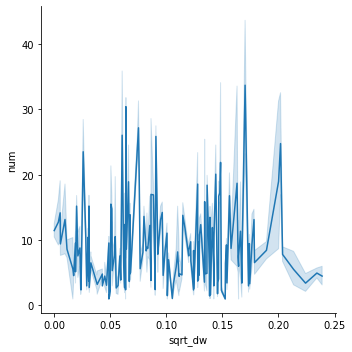

In [80]:
geo_data['sqrt_dw']=np.sqrt(geo_data['d_water'])
geo_data['sqrt_p']=np.sqrt(geo_data['d_park'])
sns.relplot(x='sqrt_dw',y='num',kind='line',data=geo_data)

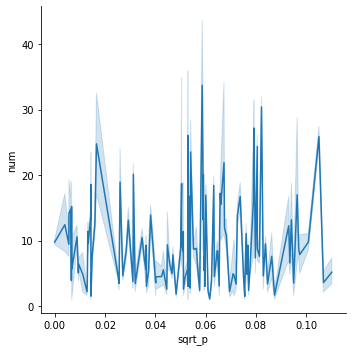

In [82]:
sns.relplot(x='sqrt_p',y='num',kind='line',data=geo_data)

In [83]:
geo_data

,year,week,TEST ID,BLOCK,trap,TRAP_TYPE,date,num,RESULT,SPECIES,...,p10,Tmax,Tmin,prec,w_sp,w_d,dtm,dtl,sqrt_dw,sqrt_p
1,2019,37,49680,17XX W ADDISON ST,T224,GRAVID,2019-09-12,9,negative,CULEX PIPIENS/RESTUANS,...,0.0,90.0,56.0,0.74,8.05,70.0,34.0,10.0,0.129137,0.027096
2,2019,37,49698,70XX W ARMITAGE AVE,T151,GRAVID,2019-09-12,8,positive,CULEX RESTUANS,...,0.0,90.0,56.0,0.74,8.05,70.0,34.0,10.0,0.136348,0.063283
3,2019,37,49681,17XX W ADDISON ST,T224,GRAVID,2019-09-12,3,negative,CULEX RESTUANS,...,0.0,90.0,56.0,0.74,8.05,70.0,34.0,10.0,0.129137,0.027096
5,2019,37,49692,14XX N HUMBOLDT DR,T033,GRAVID,2019-09-12,24,negative,CULEX PIPIENS/RESTUANS,...,0.0,90.0,56.0,0.74,8.05,70.0,34.0,10.0,0.011400,0.000000
6,2019,37,49784,4XX E 130TH ST,T221,GRAVID,2019-09-12,39,negative,CULEX PIPIENS/RESTUANS,...,0.0,90.0,56.0,0.74,8.05,70.0,34.0,10.0,0.080034,0.014381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29155,2007,24,20266,70XX W ARMITAGE AVE,T151,GRAVID,2007-06-26,6,negative,CULEX RESTUANS,...,0.0,93.0,61.0,1.08,7.16,230.0,32.0,27.0,0.136348,0.063283
29156,2007,24,20275,28XX N FRANCISCO AVE,T147,GRAVID,2007-06-26,1,negative,CULEX RESTUANS,...,0.0,93.0,61.0,1.08,7.16,230.0,32.0,27.0,0.098772,0.031207
29158,2007,24,20283,15XX W WEBSTER AVE,T045,GRAVID,2007-06-26,1,negative,CULEX PIPIENS/RESTUANS,...,0.0,93.0,61.0,1.08,7.16,230.0,32.0,27.0,0.022931,0.056370
29159,2007,24,20252,72XX N OKETO AVE,T016,GRAVID,2007-06-26,2,negative,CULEX RESTUANS,...,0.0,93.0,61.0,1.08,7.16,230.0,32.0,27.0,0.156301,0.053425


In [128]:
scaler = RobustScaler()

feature_data = geo_data[geo_data.columns.difference(['trap', 'date', 'year', 'TEST ID', 'Wards',
       'tract', 'zip', 'community', 'ward', 'geometry'])].dropna()
X = scaler.fit_transform(feature_data[feature_data.columns.difference(['num'])])
y = feature_data.num.astype(float)
lin = LinearRegression().fit(X, y)


In [129]:
lin.coef_

array([-2.74181714e+13,  1.12109375e+01, -6.73358427e+00, -2.22203896e+00,
       -7.01707005e+00, -3.26008437e-01,  3.57335206e-01,  2.44757358e+00,
       -1.76661152e+00,  4.43054433e-01, -1.10569710e+00, -5.75985619e+00,
        2.74181714e+13,  7.76769139e+00,  1.11142274e+01, -1.04737341e+00,
       -2.73144283e+00,  5.13760424e+00, -1.27746874e+01,  1.40890733e+01,
       -8.05996451e+00,  6.96980233e+00,  2.38923269e+00,  7.42795845e-01,
        6.39187095e+00, -6.17330451e+00,  2.46763543e+13,  1.10464702e+00,
       -7.90862283e+00, -7.86349425e+00,  1.46823177e-02,  2.38177550e+00,
        2.42503762e-01, -2.80151367e-01, -1.06201172e-01,  2.44140625e-03,
        1.12304688e-02,  4.74960327e-01,  1.20849609e-01, -5.21972656e-01,
       -1.23046875e-01,  1.34826660e-01, -1.75689697e-01, -1.03656006e+00,
       -5.25878906e-01, -2.56635010e+00])

In [130]:
feature_data.columns

Index(['TH0', 'TH1', 'TH10', 'TH2', 'TH3', 'TH4', 'TH5', 'TH6', 'TH7', 'TH8',
       'TH9', 'TL0', 'TL1', 'TL10', 'TL2', 'TL3', 'TL4', 'TL5', 'TL6', 'TL7',
       'TL8', 'TL9', 'Tmax', 'Tmin', 'd_park', 'd_water', 'dtl', 'dtm', 'lat',
       'lon', 'num', 'p0', 'p1', 'p10', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'prec', 'since', 'w_d', 'w_sp', 'week'],
      dtype='object')

trap        date  year          week       TEST ID          BLOCK  \
                       count     sum count   sum   count      sum count   
7911  T115  2007-07-25    64  128448    64  1856      64  1357600    64   

                                                         ... Wards          \
                                                    sum  ... count     sum   
7911  127XX S DOTY AVE127XX S DOTY AVE127XX S DOTY A...  ...    64  3008.0   

     tract            zip            community          ward          
     count      sum count        sum     count     sum count     sum  
7911    64  11136.0    64  1424000.0        64  3072.0    64  3008.0  

[1 rows x 34 columns]

In [33]:
group_traps = data.groupby('trap')
for trap in group_traps:
    temp_df = pd.DataFrame(trap)
    break
temp_df.groupby('date')

KeyError: 'date'

In [49]:
DATA.iloc[7911]

trap               T115
date         2007-07-25
year               2007
week                 29
TEST ID         21212.5
num                3002
lat             41.6624
lon            -87.5902
Wards                47
tract               174
zip               22250
community            48
ward                 47
Name: 7911, dtype: object

In [56]:
data[data.trap=='T115'][data.date==pd.to_datetime('2007-07-25')]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,year,week,TEST ID,BLOCK,trap,TRAP_TYPE,date,num,RESULT,SPECIES,lat,lon,LOCATION,Wards,tract,zip,community,ward
28553,2007,29,21214,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28558,2007,29,21238,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS/RESTUANS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28559,2007,29,21210,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28560,2007,29,21209,127XX S DOTY AVE,T115,CDC,2007-07-25,50,positive,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28561,2007,29,21202,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28639,2007,29,21182,127XX S DOTY AVE,T115,CDC,2007-07-25,1,negative,CULEX TERRITANS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28640,2007,29,21186,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28641,2007,29,21215,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0
28642,2007,29,21220,127XX S DOTY AVE,T115,CDC,2007-07-25,50,negative,CULEX PIPIENS,41.662387,-87.59018,"(41.66238672759086, -87.59017972751752)",47.0,174.0,22250.0,48.0,47.0


In [55]:
data = data.rename(columns={"TEST DATE": "date",
                            "NUMBER OF MOSQUITOES":"num",
                            "LATITUDE":"lat","LONGITUDE":"lon",
                            "TRAP":"trap",
                            "SEASON YEAR":"year",
                            "WEEK":"week",
                            "Census Tracts":"tract",
                            "Zip Codes":"zip",
                            "Community Areas":"community",
                            "Historical Wards 2003-2015":"ward"})
data['date'] = pd.to_datetime(data['date'])

In [90]:
data_to_write = geo_data[['num','lat','lon','Tmax','Tmin','prec','TH0','TL1','sqrt_dw','sqrt_p']]
data_to_write.to_csv('data/data.csv')

In [12]:
water_map = gpd.read_file('water/chicago_latlon.shp')

lake_MI = water_map[water_map.NAME == 'LAKE MICHIGAN']
water_map = water_map[water_map.NAME != 'LAKE MICHIGAN']
len(water_map)

604

In [17]:
water_maps

,DISPLAY,NAME,EDIT_DATE1,FID_,SHAPE_AREA,SHAPE_LEN,geometry
0,0,None,03-23-01,None,17756.68055,664.321573,POLYGON ((-87.69979372946455 41.84283213864926...
1,0,SANITARY AND SHIP CANAL,03-23-01,None,977448.39625,7119.384194,POLYGON ((-87.67565819832075 41.84189684946945...
2,1,SANITARY AND SHIP CANAL,03-23-01,None,18024.29250,692.950275,POLYGON ((-87.67531615295999 41.84125308936297...
3,0,None,03-23-01,None,954.36875,132.114867,"POLYGON ((-87.67216765378733 41.8414072109702,..."
4,1,SOUTH BRANCH CHICAGO RIVER,03-23-01,None,7238.91845,434.296024,POLYGON ((-87.66433144398174 41.84009604336455...
...,...,...,...,...,...,...,...
600,0,None,03-23-01,None,4330.21500,405.484950,POLYGON ((-87.65988799563851 41.84720548668022...
601,0,None,03-23-01,None,4440.32280,376.559538,"POLYGON ((-87.6597696349707 41.84720514936733,..."
602,1,SOUTH BRANCH CHICAGO RIVER,03-23-01,None,12601.09000,488.072720,POLYGON ((-87.66054101803179 41.84565537612593...
603,0,SANITARY AND SHIP CANAL,03-23-01,None,875967.70095,8249.024984,POLYGON ((-87.66604727290876 41.84519869058237...
